# Data Analysis on the KITTI Dataset

This is an initial analysis of the KITTI Dataset. It should provide basic statistics on the dataset as well as ways to leverage additional information to enrich the dataset.

This notebook will guide the reader through following steps:
* **Hello KITTI!**: How to the dataset can be read into python
* **Initial Statistics**: Basic statistics regarding class distribution and some class parameters
* **The Misc class**: Analyzing what's behind the Misc class
* **Object sizes in the image**: Creating statistics and distributions on the object sizes on the image
* **Object distribution over the driving plane**: Introducing the coverage plot for visual inspection
* **Enriching the dataset with IMU data**: How to add IMU data to the dataset and plot the location of all frames

This is by far no complete analysis of this dataset (just think lidar!). But it should give an initial feeling on what to expect from the dataset as well as some ideas on how to extend the dataset with external data sources.


## Hello KITTI!

The first step is to obtain the dataset. For just the original dataset, following bash-script can be used:
```
mkdir data
cd data
<path_to_code>/get_kitti_data_corpus.sh
```
This script will download and unzip following artefacts:
* The labels for the 3D Object Detection Dataset
* The images for the 3D Object Detection Dataset
* The pointclouds for the 3D Object Detection Dataset
* The calibration data 
* The devkit
* The raw data (later needed to enrich the dataset with more information)


Now there should be a data folder with the following structure:
```
data
|-training
  |-calib
  |-image_2
  |-label_2
  |-velodyne
|-testing
|-raw_data_downloader
```

The second step is to load the data into Python datastructures in order to work with the data.
The relation between label file and image file is given by its filename, therefore only a few parsing and path-joining operations are necessary to ingest the data into Python.

All functionality to ingest the dataset are encapsulated into the module `kitti_reader`. For each frame a dictionary is created containing the following information
* frame (dictionary)
	* image (dictionary)
        * id (str): id of the frame within the dataset
        * path (str): path to the image of the frame
        * width (int): width of the image
        * height (int): height of the image
	* detections (list of dictionaries)
        * label (str): Describes the type of object: 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',                                                  'Misc' or 'DontCare'
        * left, right, top, bottom (int): 2D bounding box of object in the image: contains left, top, right, bottom pixel coordinates
        * truncated (float): Float from 0 (non-truncated) to 1 (truncated), where truncated refers to the object leaving image boundaries
        * occluded (int): Integer (0,1,2,3) indicating occlusion state:                                                     0 = fully visible, 1 = partly occluded, 2 = largely occluded,                                                     3 = unknown
        * alpha (float): Observation angle of object, ranging [-pi..pi]
        * height, width, length (float): 3D object dimensions: height, width, length (in meters)
        * pos_x, pos_y, pos_z (float): 3D object location x,y,z in camera coordinates (in meters)
        * rot_y: Rotation ry around Y-axis in camera coordinates [-pi..pi]
    * velodyne (dictionary)
        * path (str): path to the binary velodyne file. The data can be loaded into a numpy array by using `kitti_reader.KITTIFrameReader.get_velodyne(frame)`
    * calibration (dictionary)
        * P0-P3: 3x4 matrix
        * R0_rect: 4x4 matrix
        * Tr_velo_to_cam: 4x4 matrix
        * Tr_imu_to_velo: 4x4 matrix



In [1]:
from kitti_reader import KITTIFrameReader

# path to the data folder
path = r'/media/drivepx/BA0C-0F69/kitti/data'

reader = KITTIFrameReader(path)
frames = reader.read_all_frames()


## Initial Statistics

With that, we can already create the very first statistics regarding the dataset. 

From the readme of the dataset, we know the names of the labels. The "DontCare" labels are not really labels, they are regions in the frame, which specifically were not labeled. This is done to avoid accuracy evaluation in these regions, as it is just unknown, if there are objects or if there are not. Therefore the "DontCare" class is omitted during further investigation.

Total number of frames: 7481
Total number of labeled objects: 40570
--------------
Car                            28742       70.8%
Van                             2914        7.2%
Truck                           1094        2.7%
Pedestrian                      4487       11.1%
Person_sitting                   222        0.5%
Cyclist                         1627        4.0%
Tram                             511        1.3%
Misc                             973        2.4%


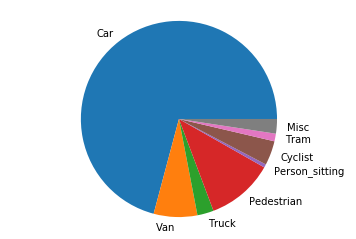

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

label_classes = ['Car', 'Van', 'Truck',
                 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                 'Misc']

detections = {lbl:[] for lbl in label_classes}


for f in frames:
    for lbl in label_classes:
        detections[lbl] += [d for d in f['detections'] if d['label'] == lbl]

total_objects = sum([len(detections[lbl]) for lbl in label_classes])

print("Total number of frames: {}".format(len(frames)))
print("Total number of labeled objects: {}".format(total_objects))
print("--------------")
for lbl in label_classes:
    print("{:25} {:10d} {:10.1f}%".format(lbl, len(detections[lbl]), len(detections[lbl])/total_objects*100.0))
    
    
plt.pie([len(detections[lbl]) for lbl in label_classes], labels=label_classes)

plt.axis('equal')
plt.show()

## Visualize
Let's visualize the data. The first 3 plots show the scene from the camera's perspective. The 4th plot shows the scene from Bird's eye view perspective (origin is velodyne coordinate system).

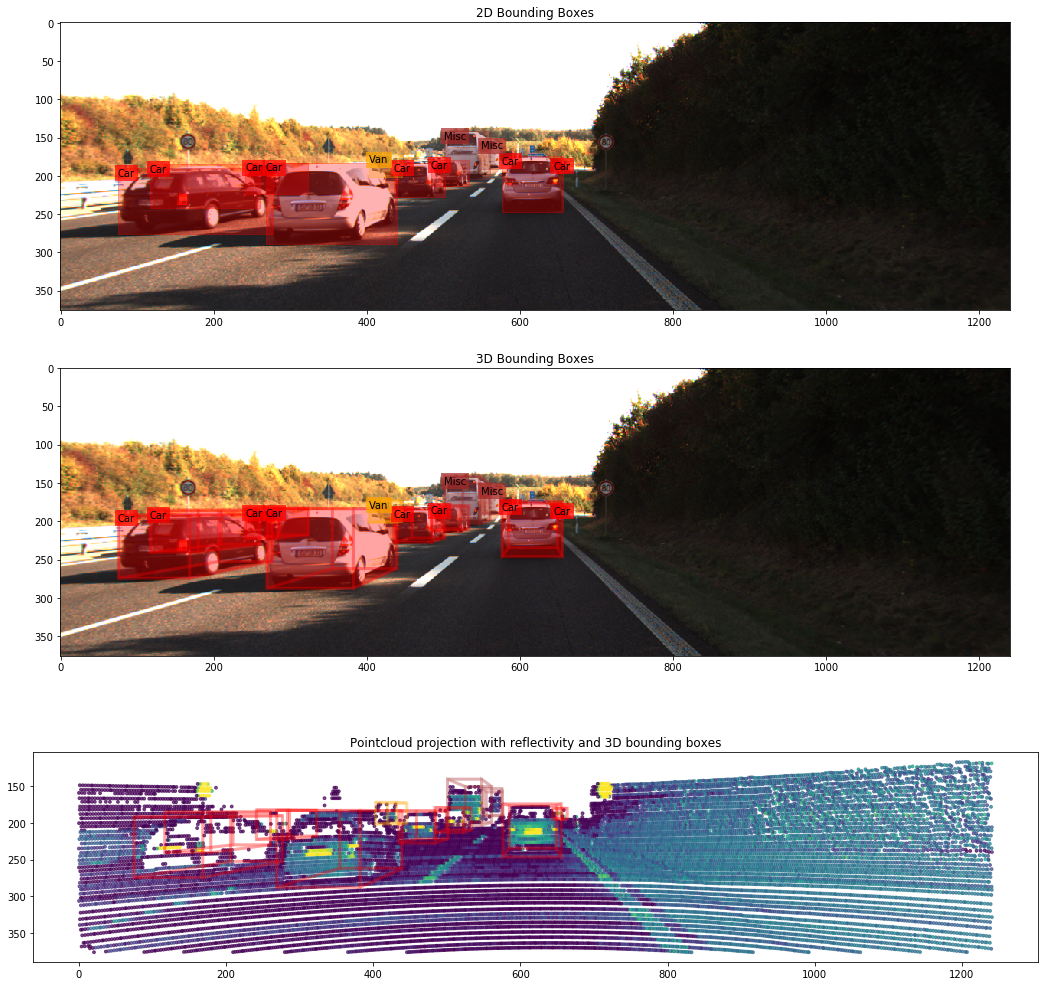

In [3]:
import matplotlib.pyplot as plt
import plot_helpers

frame_id = 357
fig = plt.figure(figsize=(18,18))
ax = plt.subplot(311)
plot_helpers.plot_frame_2d(ax, frames[frame_id], show_image=True, show_2d=True, show_3d=False, show_info=True, show_lidar=False)
ax.set_title('2D Bounding Boxes')
ax = plt.subplot(312)
plot_helpers.plot_frame_2d(ax, frames[frame_id], show_image=True, show_2d=False, show_3d=True, show_info=True, show_lidar=False)
ax.set_title('3D Bounding Boxes')
ax = plt.subplot(313)
plot_helpers.plot_frame_2d(ax, frames[frame_id], show_image=False, show_2d=False, show_3d=True, show_info=False, show_lidar=True)
ax.set_title('Pointcloud projection with reflectivity and 3D bounding boxes')
print(' ')

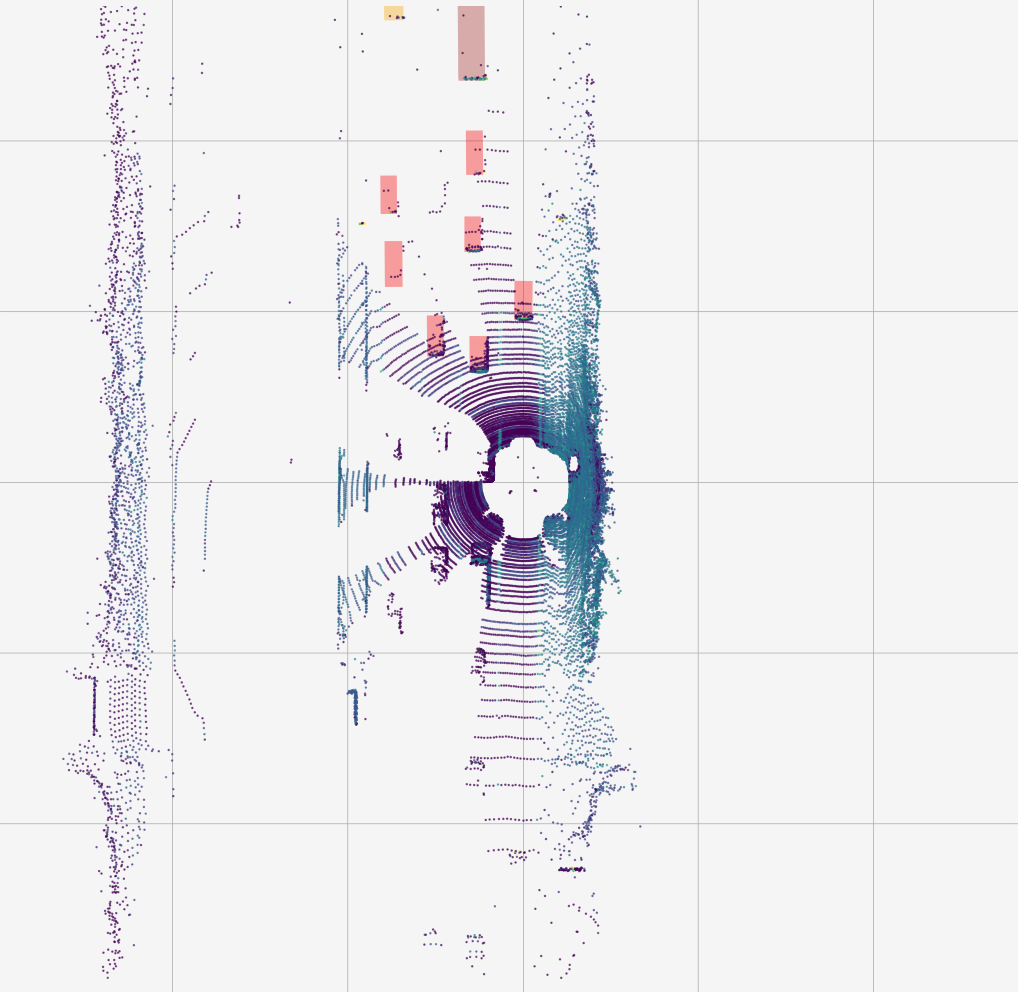

In [4]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plot_helpers.plot_frame_3d(ax, frames[frame_id], show_lidar=True)
ax.view_init(elev=90, azim=180)
ax.dist = 3

With these visualization tools we can start investigating the data in order to do sanity checks. 

## Sanity checks

### 3D Bounding box dimensions
Let's check the 3D Bounding box properties distribution. With that, we can hopefully find outliers because of bad labeling.

Label                length                 width                  height                 
--------------------+----------------------+----------------------+---------------------- 
Car                    2.19/  3.88/  6.67 m    1.14/  1.63/  2.04 m    1.14/  1.53/  2.48 m 
Van                    3.18/  5.08/  6.91 m    1.52/  1.90/  2.52 m    1.65/  2.21/  2.91 m 
Truck                  5.42/ 10.11/ 16.79 m    2.06/  2.59/  3.01 m    2.32/  3.25/  4.20 m 
Pedestrian             0.20/  0.84/  1.44 m    0.30/  0.66/  1.20 m    1.14/  1.76/  2.01 m 
Person_sitting         0.50/  0.80/  1.33 m    0.48/  0.59/  0.78 m    1.05/  1.27/  1.64 m 
Cyclist                1.19/  1.76/  2.17 m    0.34/  0.60/  0.93 m    1.41/  1.74/  2.09 m 
Tram                   3.14/ 16.09/ 35.24 m    2.05/  2.54/  2.81 m    2.99/  3.53/  3.84 m 
Misc                   0.77/  3.58/ 12.60 m    0.40/  1.51/  2.68 m    0.76/  1.91/  3.91 m 


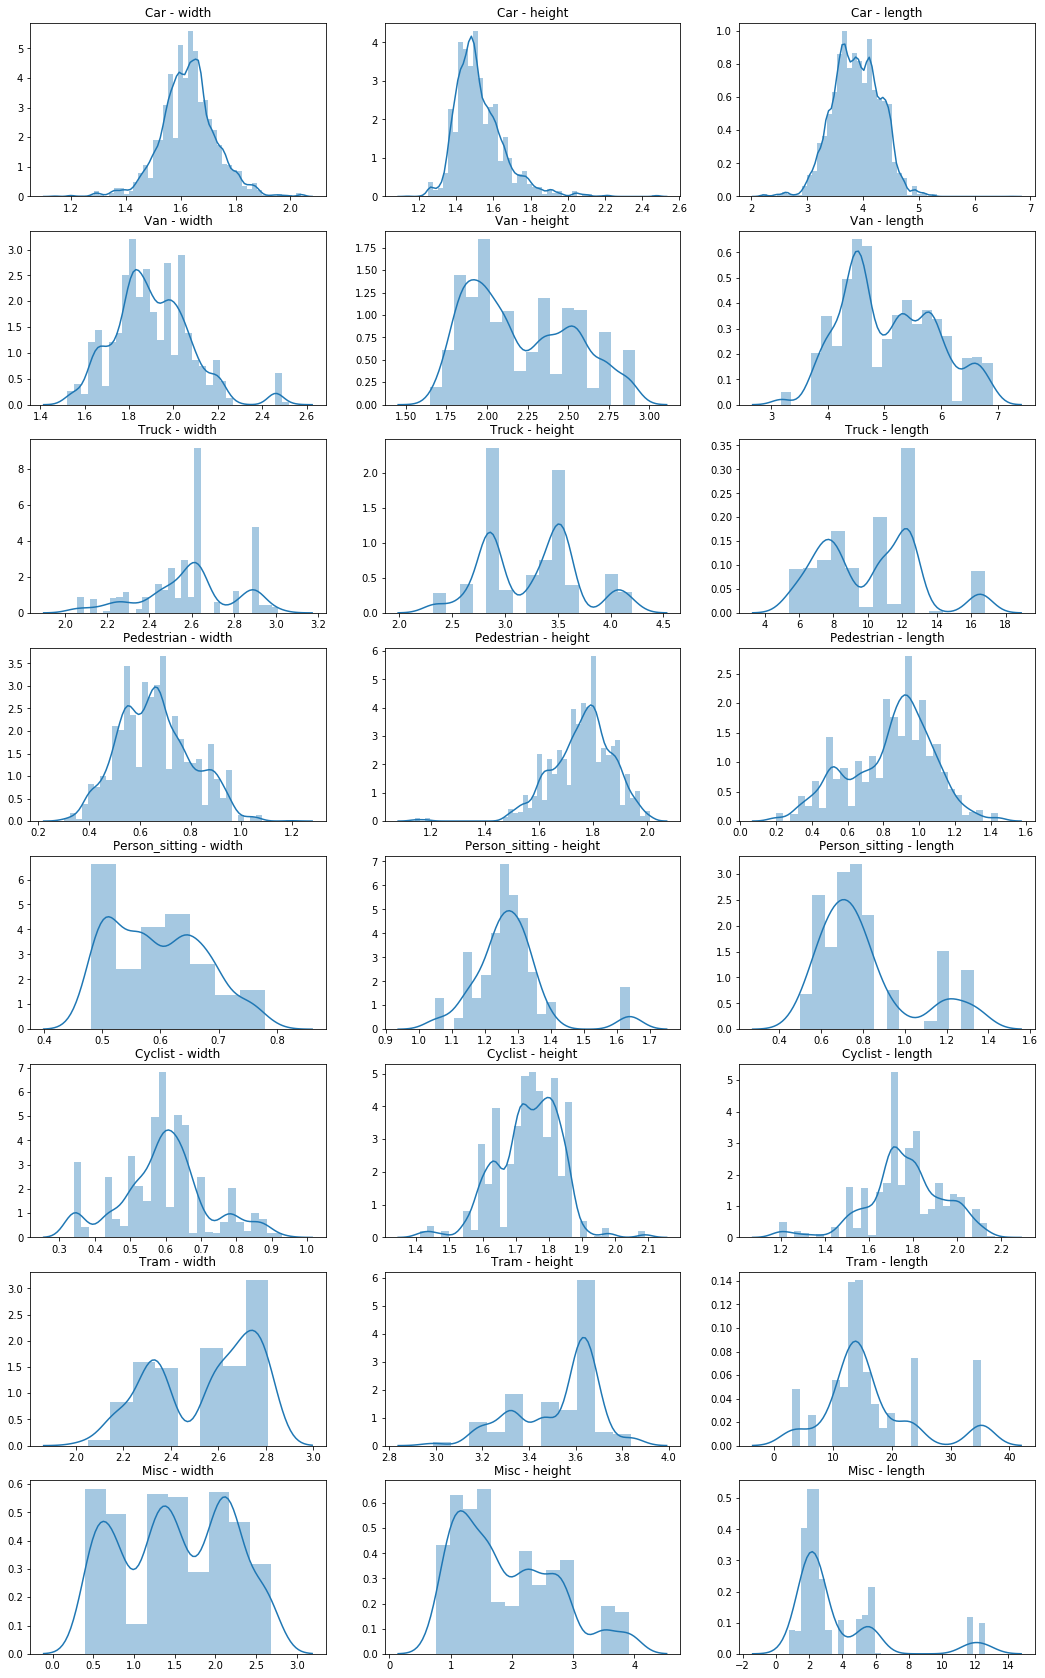

In [5]:
import numpy as np
import seaborn as sbn

print("{:20} {:22} {:22} {:22} ".format(
        'Label', 
        'length',
        'width',
        'height'
    ))
print("{:-^20}+{:-^22}+{:-^22}+{:-^22} ".format("","","",""))

fig = plt.figure(figsize=(18, 30))

for idx, lbl in enumerate(label_classes):
    heights = np.array([d['height'] for d in detections[lbl]])
    widths = np.array([d['width'] for d in detections[lbl]])
    lengths = np.array([d['length'] for d in detections[lbl]])

    # print a table
    print("{:20} {:6.2f}/{:6.2f}/{:6.2f} m  {:6.2f}/{:6.2f}/{:6.2f} m  {:6.2f}/{:6.2f}/{:6.2f} m ".format(
        lbl, 
        lengths.min(), lengths.mean(), lengths.max(),
        widths.min(), widths.mean(), widths.max(),
        heights.min(), heights.mean(), heights.max(),
    ))
    
    # plot the distirbutions
    ax = plt.subplot(len(label_classes), 3, idx*3+1)
    ax.autoscale(axis='both')
    ax.set_title("{} - width".format(lbl))
    sbn.distplot(widths, label="width")
    
    ax = plt.subplot(len(label_classes), 3, idx*3+2)
    ax.autoscale(axis='both')
    ax.set_title("{} - height".format(lbl))
    sbn.distplot(heights, label="height")
    
    ax = plt.subplot(len(label_classes), 3, idx*3+3)
    ax.autoscale(axis='both')
    ax.set_title("{} - length".format(lbl))
    sbn.distplot(lengths, label="length")

    
    
plt.show(fig)

#### Car

The car width seems to be a little bit on the smaller side, presumably because side mirrors are not part of the bounding box. Additionally the shortest and the longest car seem a bit suspicious - an A8L is not longer than 5.4m, so the maximum of 6.7m is quite a long car. Also the shortest car within the dataset (2.19m) is shorter than the 2.5m of an old Smart Fortwo.

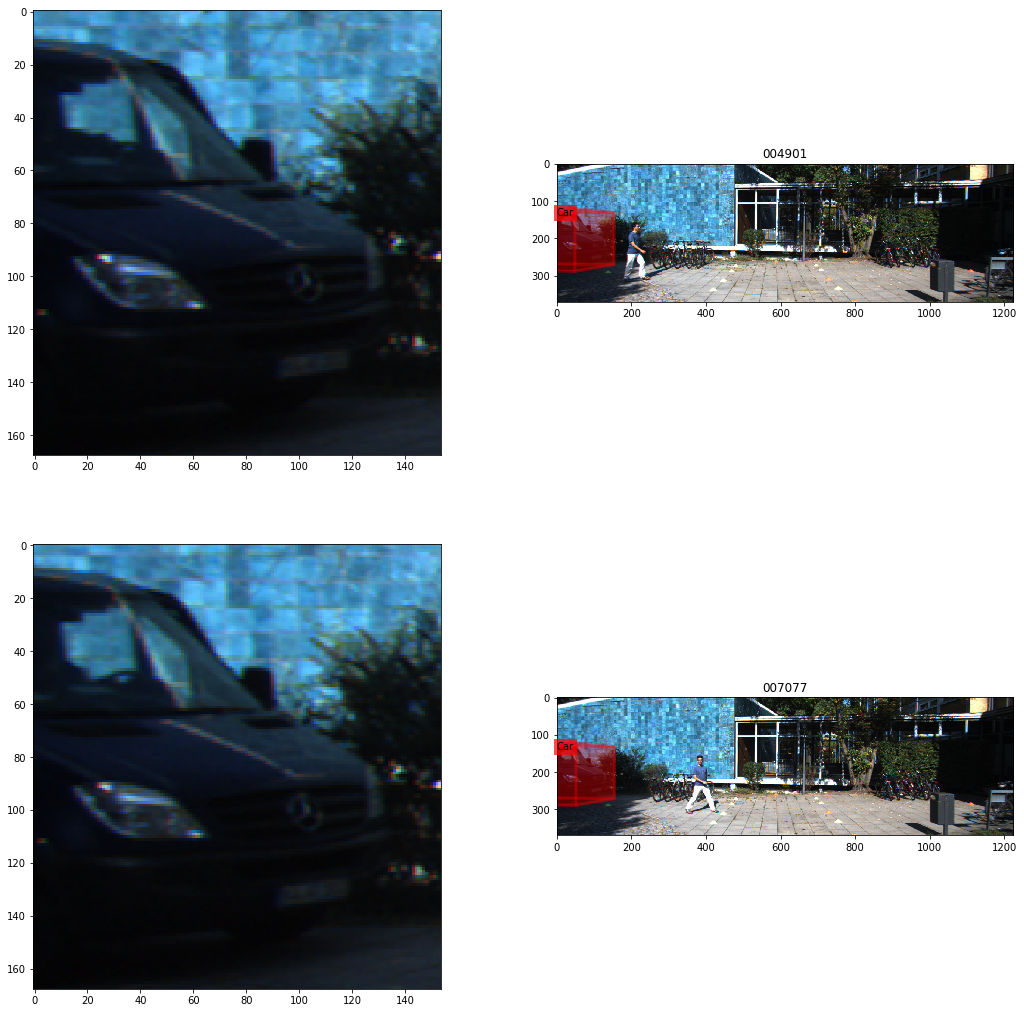

In [6]:
from plot_helpers import crop_detection


fig = plt.figure(figsize=(18, 18))

for idx, data in enumerate([(f,d) for f in frames for d in f['detections'] if (d['length']>5.5) and d['label']=='Car']):
    ax = plt.subplot(2,2, (2*idx)+1)
    plt.imshow(crop_detection(data[0]['image']['path'], data[1]), aspect="equal")
    cur_frame = KITTIFrameReader.create_new_frame_from_detections(data[0], [data[1]])

    ax = plt.subplot(2,2, (2*idx)+2)
    plot_helpers.plot_frame_2d(ax, cur_frame, show_image=True, show_2d=False, show_3d=True, show_info=True, show_lidar=False)
    ax.set_title(cur_frame['image']['id'])
        
plt.show(fig)

Clearly, in this case the label is wrong for this instance in the frames with id 4901 and 7077. The 'car' is a Mercedes Benz Sprinter, which can indeed be >6m long, but it is definitely a 'van'.

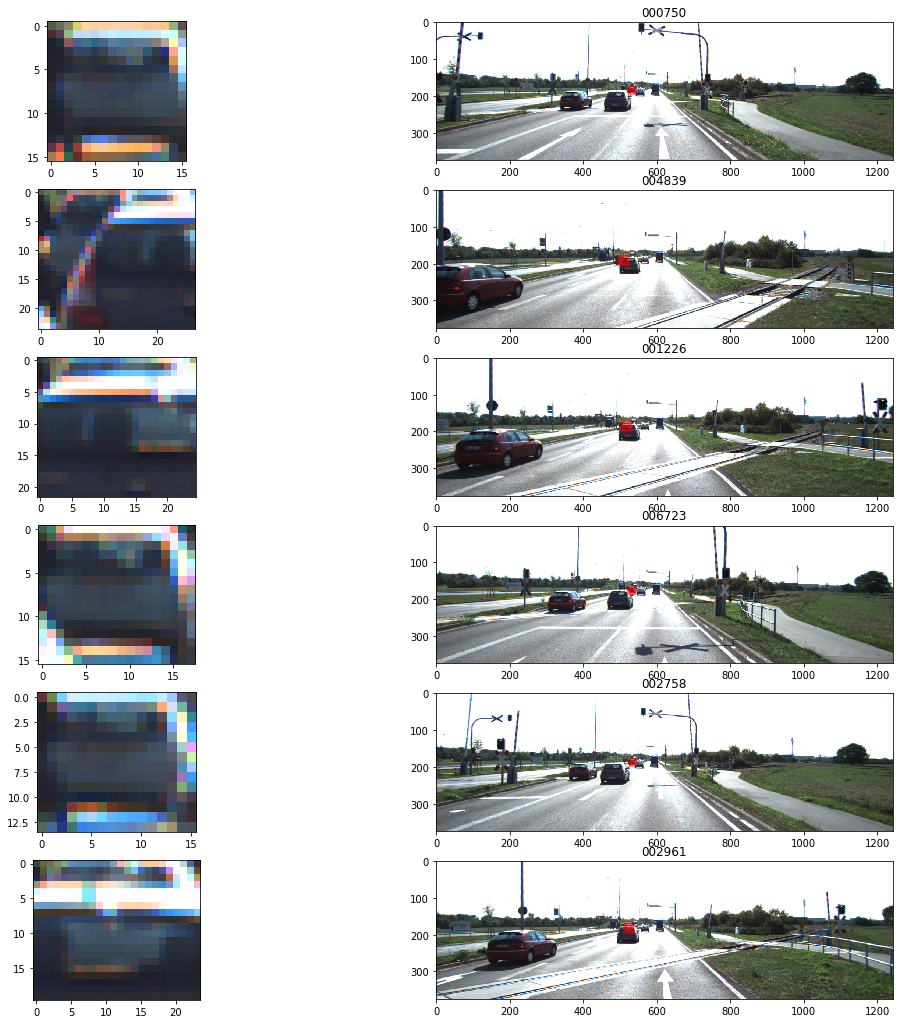

In [7]:
from plot_helpers import crop_detection

fig = plt.figure(figsize=(18, 18))

findings = [(f,d) for f in frames for d in f['detections'] if (d['length']<2.2) and d['label']=='Car']

for idx, data in enumerate(findings):
    ax = plt.subplot(len(findings),2, (2*idx)+1)
    plt.imshow(crop_detection(data[0]['image']['path'], data[1]), aspect="equal")
    cur_frame = KITTIFrameReader.create_new_frame_from_detections(data[0], [data[1]])

    ax = plt.subplot(len(findings),2, (2*idx)+2)
    plot_helpers.plot_frame_2d(ax, cur_frame, show_image=True, show_2d=False, show_3d=True, show_info=False, show_lidar=False)
    ax.set_title(cur_frame['image']['id'])
        
plt.show(fig)

This case seems just like some inaccuarcy - as the vehicle is quite far away, it is unclear, how the length is measured at all. The next plot shows, that the vehicle is hit only by one velodyne beam. 

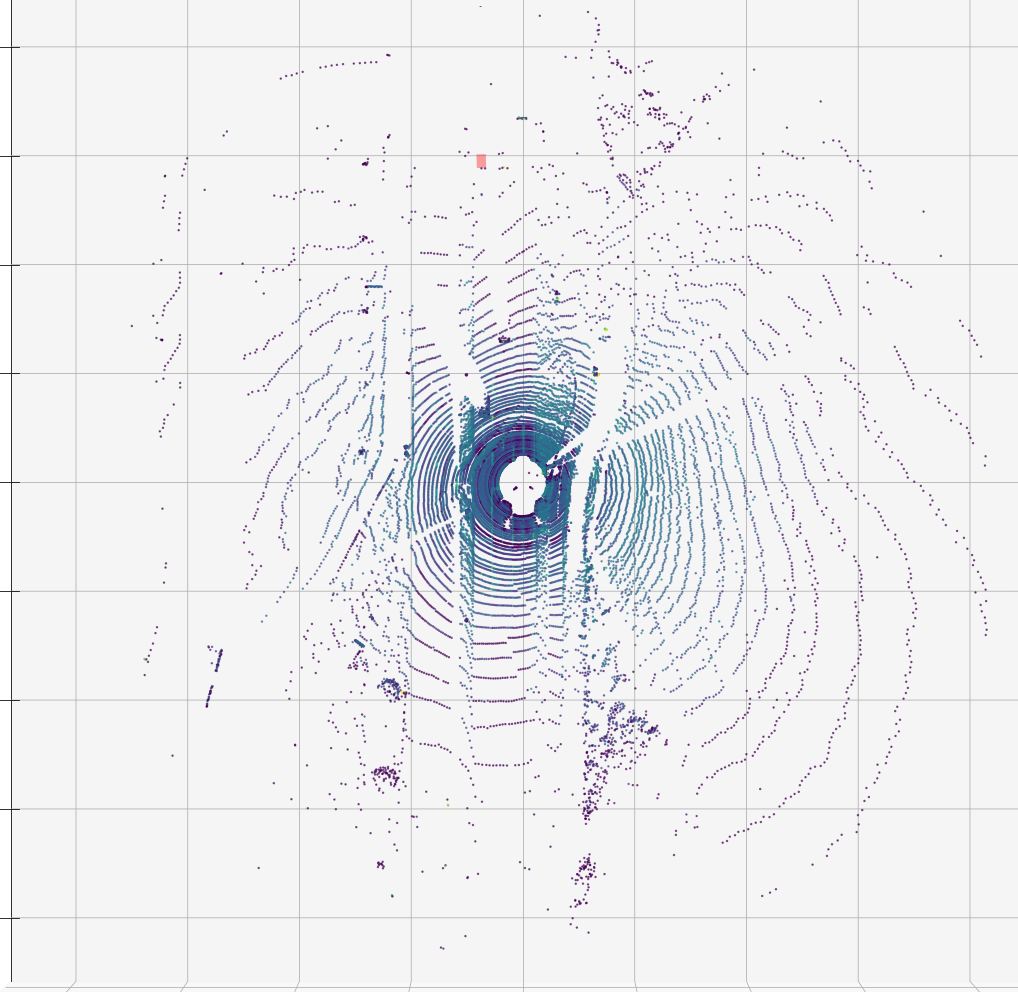

In [8]:
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(1, 1, 1, projection='3d')
cur_frame = KITTIFrameReader.create_new_frame_from_detections(findings[-1][0], [findings[-1][1]])
plot_helpers.plot_frame_3d(ax, cur_frame, show_lidar=True)
ax.view_init(elev=90, azim=180)
ax.dist = 5

#### Truck and Tram

Trucks and Trams have quite a big standard deviation in length. In particular, trucks have distinctive bump in their length distribution. This can be explained by the different standard european truck configurations - it can be a semi-truck or a standard 2 or 3 axle truck.
For trams the bump is not that distinctive, but again, different tram configurations (multiple cars) can explain the high variance in tram length.


#### Pedestrians, sitting persons and cyclists

The dimensions of these classes raise no obvious concerns. A height of 2m is well within the possibilities for Cyclists and Persons, 1.64m height for sitting persons also seems to be fine.

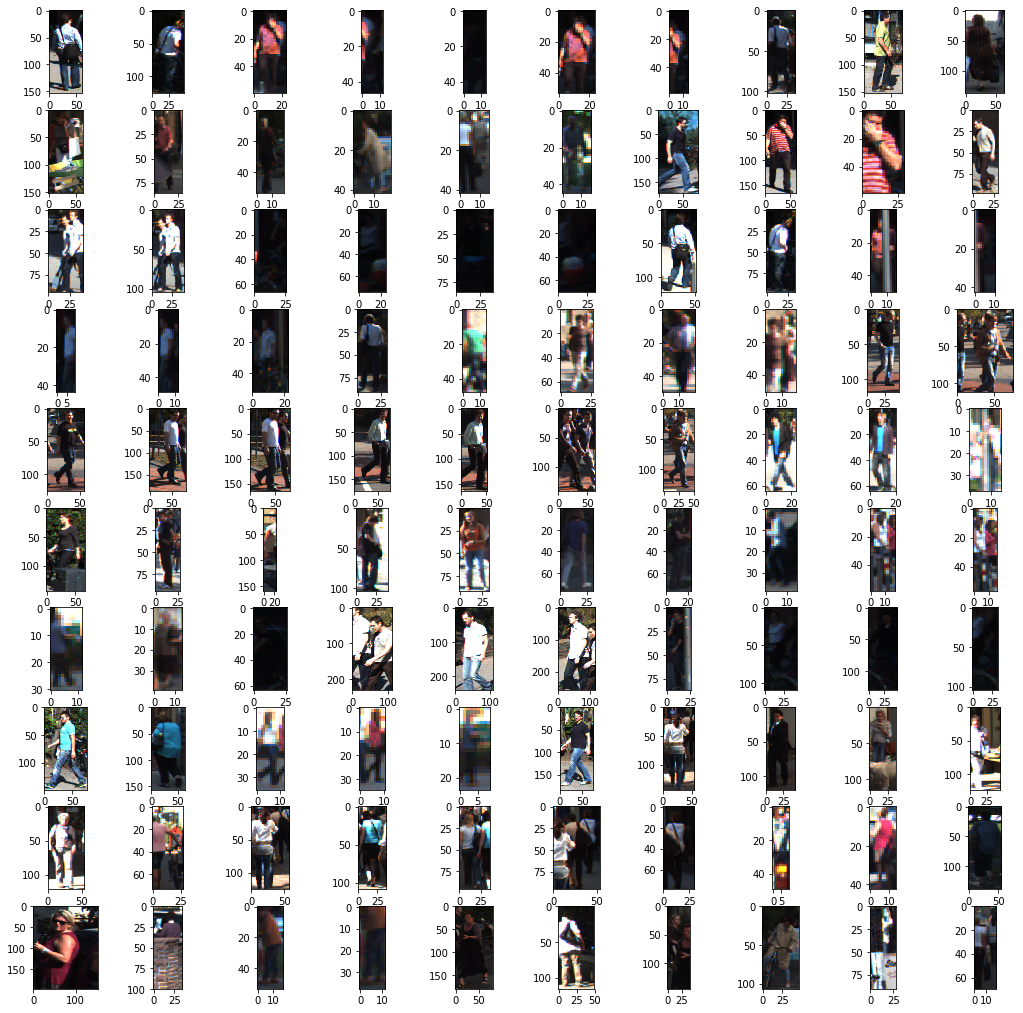

In [9]:
from plot_helpers import crop_detection
grid = (10,10)
fig = plt.figure(figsize=(18, 18))
for idx, data in enumerate([(f,d) for f in frames for d in f['detections'] if d['label']=='Pedestrian']):
    ax = plt.subplot(grid[0],grid[1], idx+1)
    plt.imshow(crop_detection(data[0]['image']['path'], data[1]), aspect="equal")

    if idx >= grid[0]*grid[1]-1:
        break
        
plt.show(fig)

#### Misc class

The "Misc" class seems a little bit mysterious. So let's have a look at a few examples.

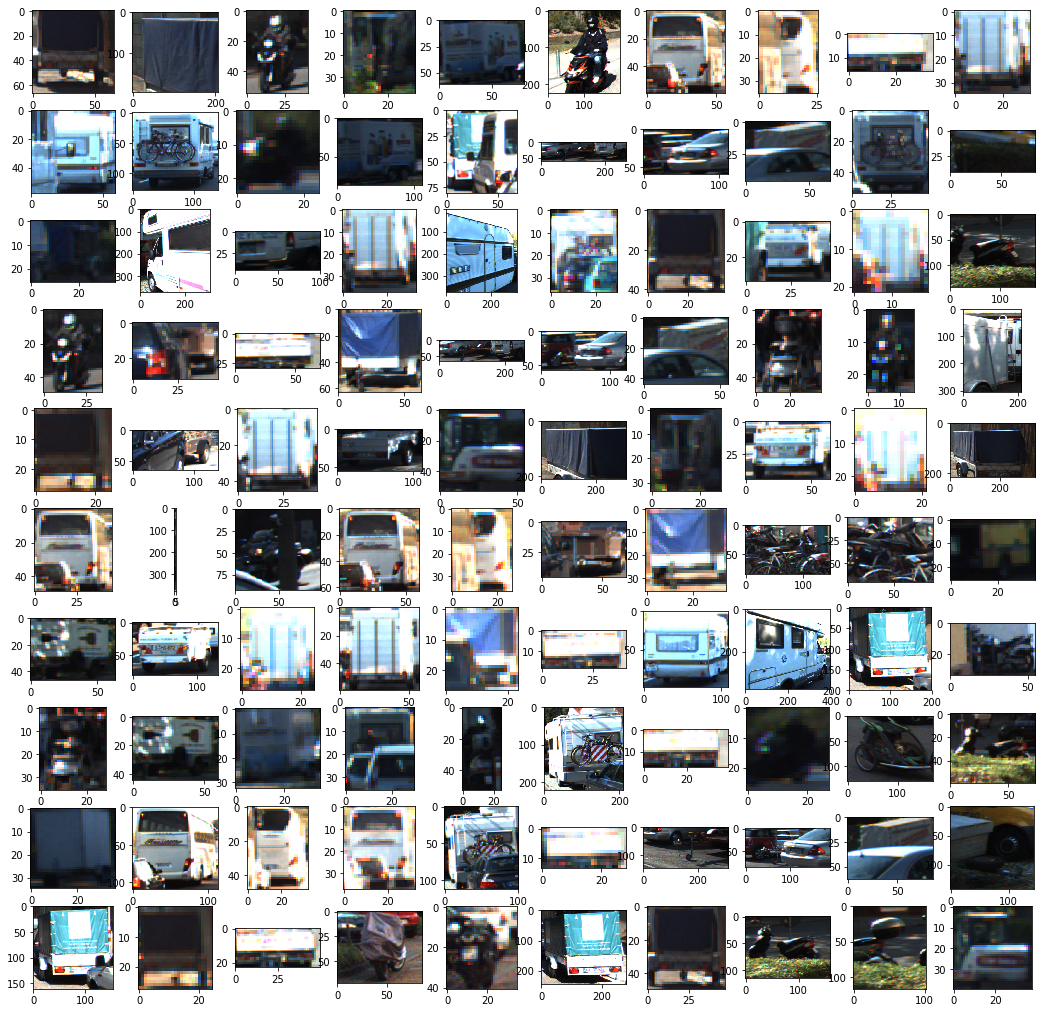

In [10]:
from plot_helpers import crop_detection
grid = (10,10)
fig = plt.figure(figsize=(18, 18))
for idx, data in enumerate([(f,d) for f in frames for d in f['detections'] if d['label']=='Misc']):
    ax = plt.subplot(grid[0],grid[1], idx+1)
    plt.imshow(crop_detection(data[0]['image']['path'], data[1]), aspect="equal")

    if idx >= grid[0]*grid[1]-1:
        break
        
plt.show(fig)


There we go. It seems, that the "Misc"-class contains among others: 
* caravans
* trailers
* motor-bikes/scooters
* coaches
* mini-diggers

Especially for training a neural network I personally think it is hard to train for this particular class. Coaches are much more similiar to trucks an the network will get confused when to predict trucks and when "Misc". I would take special care of this class within evaluation and KPI calculation, as it will be most likely a wrong class prediction (e.g. truck or bicycle instead of misc), but an object should still be detected.

### 2D Bounding Box Dimensions

Besides the physical size of the object, the size in the pixel space is also of interest, as this is the amount of information which is available for a particular object from the image sensor.

Misc                 width (min/mean/max)     height (min/mean/max)    aspect ratio (min/mean/max) 
--------------------+------------------------+------------------------+------------------------ 
Car                    0.46/111.95/581.42 px  12.67/ 66.12/334.53 px   0.02/  1.72/  3.99
Van                    3.24/109.65/537.01 px  16.89/ 83.60/375.00 px   0.01/  1.40/  2.99
Truck                  1.83/ 99.72/509.91 px  26.69/ 86.41/375.00 px   0.00/  1.20/  4.36
Pedestrian             0.11/ 43.82/358.42 px  13.52/103.72/294.48 px   0.01/  0.40/  1.41
Person_sitting         3.86/ 83.64/230.41 px  31.74/102.28/226.54 px   0.03/  0.82/  2.00
Cyclist                6.21/ 55.85/369.83 px  16.16/ 76.89/294.66 px   0.07/  0.69/  1.87
Tram                  24.25/153.41/537.41 px  20.18/104.22/374.00 px   0.25/  1.58/  3.49
Misc                   5.04/ 90.72/454.02 px  13.17/ 74.46/375.00 px   0.01/  1.28/  5.16


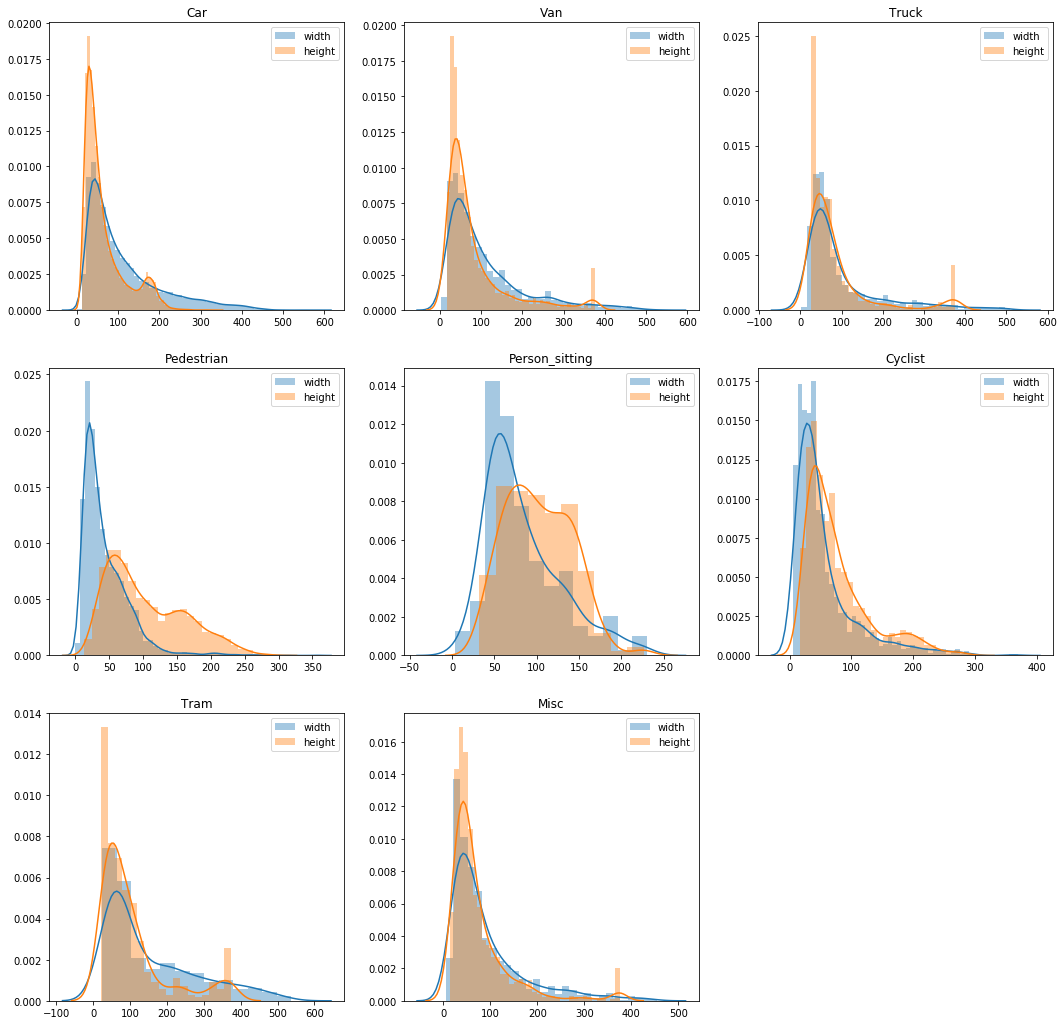

In [11]:
import numpy as np
import seaborn as sbn

print("{:20} {:24} {:24} {:24} ".format(
        lbl, 
        'width (min/mean/max)',
        'height (min/mean/max)',
        'aspect ratio (min/mean/max)'
    ))
print("{:-^20}+{:-^24}+{:-^24}+{:-^24} ".format("","","",""))

fig = plt.figure(figsize=(18, 18))

for idx, lbl in enumerate(label_classes):
    widths = np.array([d['right']-d['left'] for d in detections[lbl]])
    heights = np.array([d['bottom']-d['top'] for d in detections[lbl]])
    aspect = widths/heights
    
    print("{:20} {:6.2f}/{:6.2f}/{:6.2f} px {:6.2f}/{:6.2f}/{:6.2f} px {:6.2f}/{:6.2f}/{:6.2f}".format(
        lbl, 
        widths.min(), widths.mean(), widths.max(),
        heights.min(), heights.mean(), heights.max(),
        aspect.min(), aspect.mean(), aspect.max(),
    ))
    
    ax = plt.subplot(3,3, idx+1)
    ax.autoscale(axis='both')
    ax.set_title(lbl)
    sbn.distplot(widths, label="width")
    sbn.distplot(heights, label="height")
    ax.legend()
        
plt.show(fig)
    

Here especially the min values are of interest - nearly all calsses have very small minimum widths. If a classifier should be trained on the images using the 2D bounding box, the very small objects should be excluded. Depending on the design of the classifier, the exclusion threshold should be selected accordingly.

That there are no negative values is a good sign - this means, that no bounding box is flipped. 

Finally, it is worth checking if all bounding boxes are within the image boundaries:

In [12]:
detections_outside_image = [(f,d) for f in frames for d in f['detections'] \
                            if (d['right']>=f['image']['width']) and (d['bottom']>=f['image']['height']) \
                           and (d['left']<0) and (d['top']<0)]

print("Number of detections outside the image: {}".format(len(detections_outside_image)))
    

Number of detections outside the image: 0


### 3D Bounding Box location and orientation

The first simple checks to do: 
* Are all orientations within the specified [-pi ... pi] range?
* Are all objects in front of the camera plane?

In [13]:
detections_orientation_oor = [(f,d) for f in frames for d in f['detections'] \
                            if (d['label']!='DontCare') 
                              and not (-np.pi <= d['rot_y'] <= np.pi)
                              and not (-np.pi <= d['alpha'] <= np.pi)]

print("Number of detections with orientations outside of [-pi...pi]: {}"
      .format(len(detections_orientation_oor)))

Number of detections with orientations outside of [-pi...pi]: 0


In [14]:
detections_pos_oor = [(f,d) for f in frames for d in f['detections'] \
                            if (d['label']!='DontCare') 
                              and d['pos_z'] < 0.0]

print("Number of detections behind the camera plane: {}"
      .format(len(detections_pos_oor)))

for finding in detections_pos_oor:
    print("#{:6} truncated: {:6.2}  occluded: {}"
          .format(finding[0]['image']['id'], finding[1]['truncated'], finding[1]['occluded']))

Number of detections behind the camera plane: 8
#001628 truncated:    1.0  occluded: 0
#003216 truncated:    1.0  occluded: 0
#000301 truncated:    1.0  occluded: 0
#005029 truncated:    1.0  occluded: 0
#002520 truncated:    1.0  occluded: 0
#003396 truncated:    1.0  occluded: 0
#004825 truncated:    1.0  occluded: 0
#002465 truncated:    1.0  occluded: 0


That is interesting. 8 objects habve their center behind the image plane and are therfore mostly invisible. At least they are marked as fully truncated (`truncated = 1.0`). Let's visualize these frames.

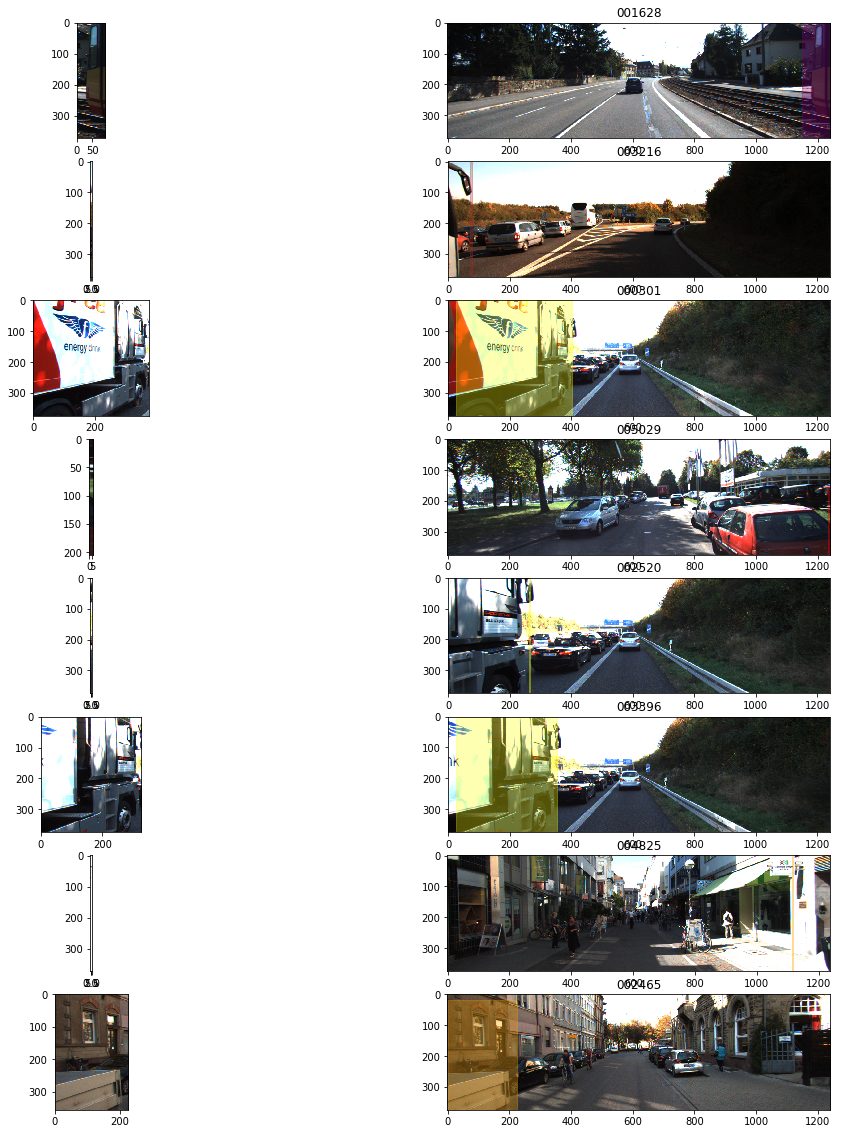

In [15]:
fig = plt.figure(figsize=(18, 20))

for idx, data in enumerate(detections_pos_oor):
    ax = plt.subplot(len(detections_pos_oor),2, (2*idx)+1)
    plt.imshow(crop_detection(data[0]['image']['path'], data[1]), aspect="equal")
    cur_frame = KITTIFrameReader.create_new_frame_from_detections(data[0], [data[1]])

    ax = plt.subplot(len(detections_pos_oor),2, (2*idx)+2)
    plot_helpers.plot_frame_2d(ax, cur_frame, show_image=True, show_2d=True, show_3d=False, show_info=False, show_lidar=False)
    ax.set_title(cur_frame['image']['id'])
        
plt.show(fig)

By looking at these examples, it seems reasonable to mask these fully truncated objects as `DontCare`, if the image is used to classify them. Also very tiny aspect ratios should be removed from the training set.

To investigate the spatial distribution of the objects, the aggregated locations of the objects are plotted by class. So it is easy to spot uneven distributions in the location of the classes. 

The class `CoveragePlot` creates a birds-eye-view for all given detections. The origin is the camera position.

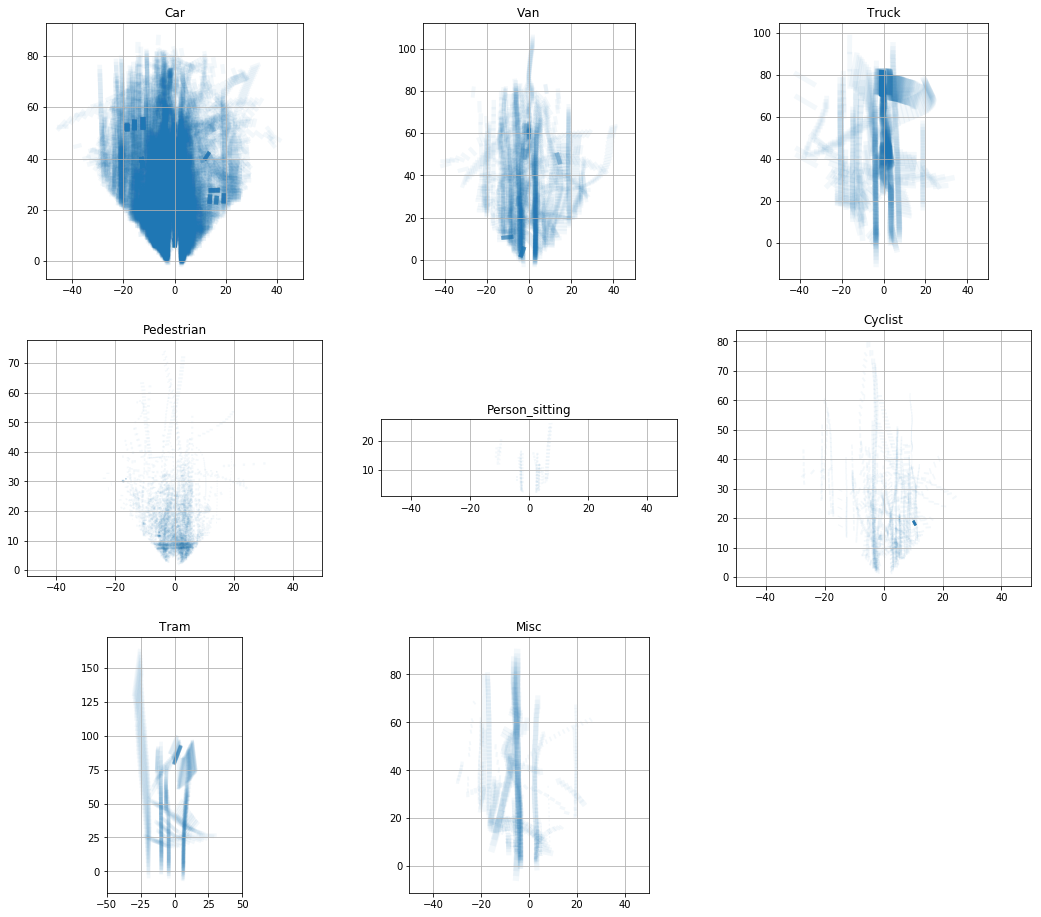

In [16]:
from plot_helpers import CoveragePlot

fig = plt.figure(figsize=(18, 16))
for idx, lbl in enumerate(label_classes):
    ax = plt.subplot(3,3, idx+1)
    CoveragePlot(detections[lbl], ax, 0.05)
    ax.set_xlim([-50, 50])
    ax.set_aspect('equal')
    ax.autoscale(axis='y')
    ax.set_title(lbl)
    ax.grid(True)


plt.show(fig)

These plots make it quite obvious, that only within the car and pedestrian classes all objects are well distributed over the camera perception cone. All other classes have serious white spots. So if this dataset is used to validate the performance of an algorithm, no reliable statement can be given for those white spots.

Additionally, the classes car, van and cyclist contain interesting hot spots - detections, which obviously occur in multiple frames at the exact same position (e.g. at consecutive frames at a traffic light).

These plots only sanity checks the location in the x-z plane. For completeness, also look at the objects distributions in y direction (location above the ground)

Label                pos x (min/mean/max)   pos y (min/mean/max)   pos z (min/mean/max)   
--------------------+----------------------+----------------------+---------------------- 
Car                  -44.03/ -2.40/ 39.86 m   -2.14/  1.71/  4.09 m   -0.18/ 28.01/ 86.18 m 
Van                  -39.65/ -0.53/ 40.06 m   -0.64/  1.63/  5.93 m   -0.57/ 34.67/103.60 m 
Truck                -37.45/ -1.33/ 28.09 m    0.38/  1.77/  3.11 m   -3.55/ 47.15/ 94.44 m 
Pedestrian           -23.76/ -0.12/ 30.42 m   -0.27/  1.43/  3.37 m    2.05/ 17.43/ 73.93 m 
Person_sitting       -11.21/  0.79/  7.27 m    0.39/  1.49/  1.93 m    2.73/ 10.53/ 25.72 m 
Cyclist              -27.21/  1.11/ 24.06 m    0.17/  1.57/  4.05 m    2.00/ 24.66/ 78.97 m 
Tram                 -27.96/ -1.20/ 24.57 m    0.57/  1.70/  3.58 m   -0.20/ 48.30/146.85 m 
Misc                 -29.73/ -3.66/ 25.76 m   -0.11/  1.66/  4.40 m   -0.28/ 29.95/ 84.43 m 


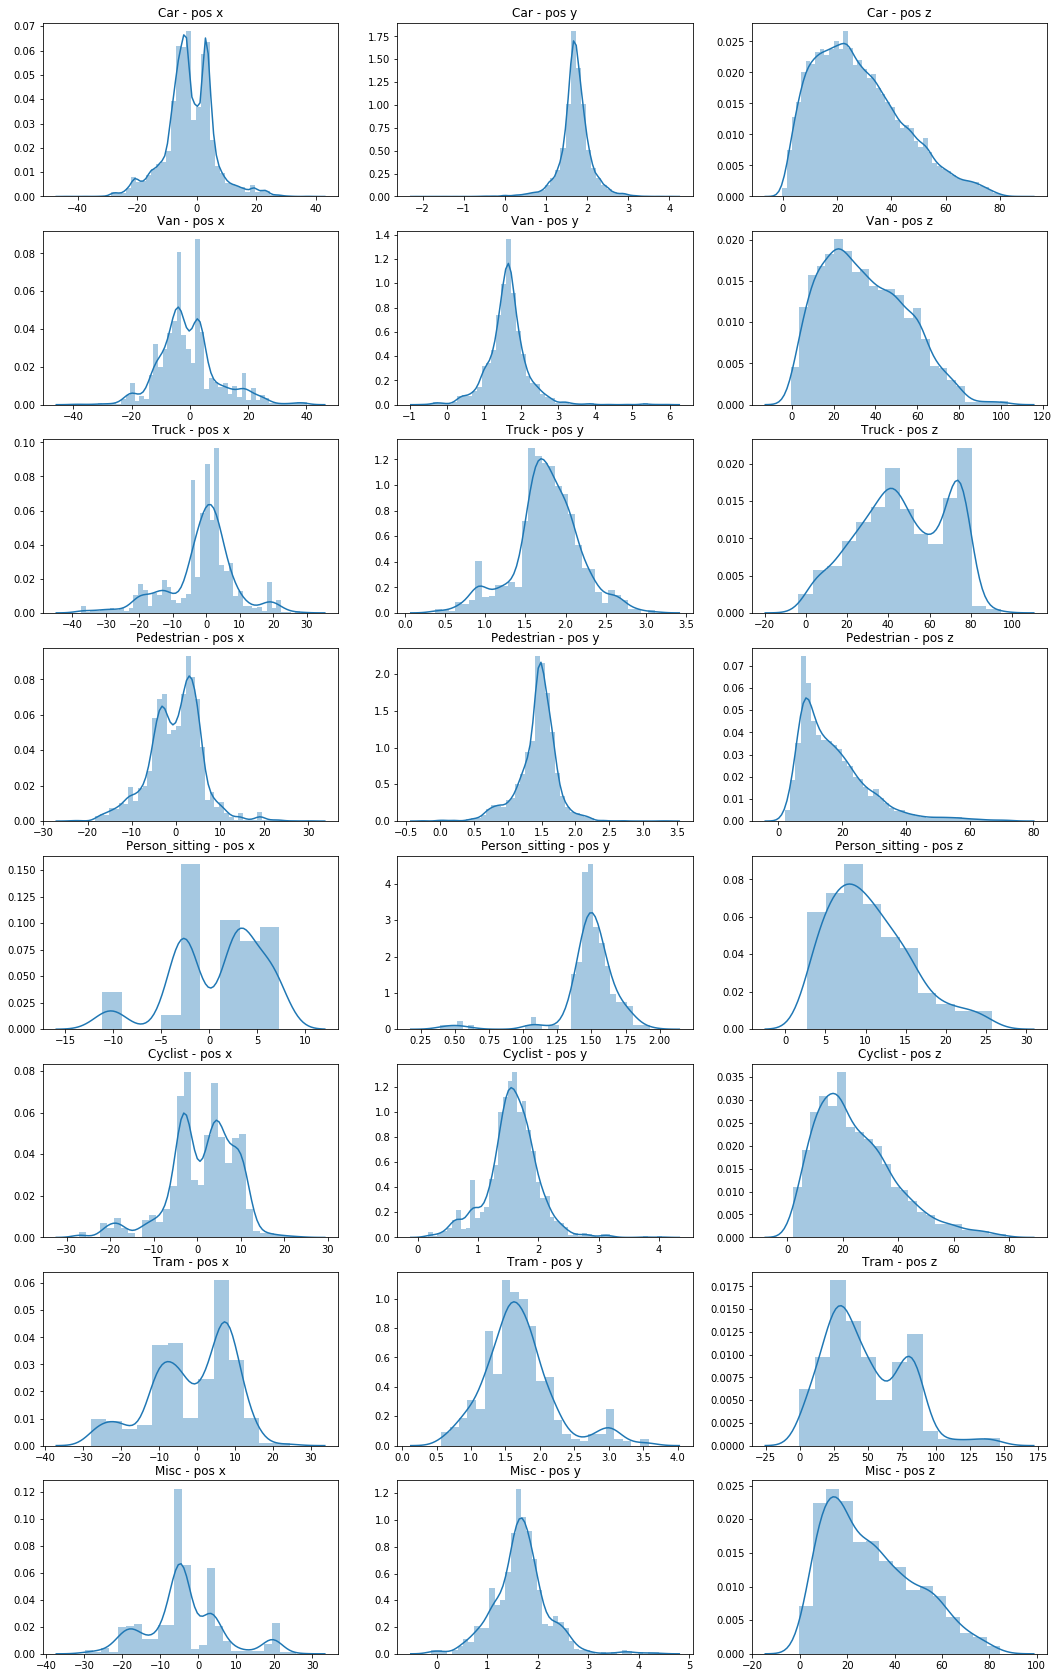

In [17]:
import numpy as np
import seaborn as sbn

print("{:20} {:22} {:22} {:22} ".format(
        'Label', 
        'pos x (min/mean/max)',
        'pos y (min/mean/max)',
        'pos z (min/mean/max)'
    ))
print("{:-^20}+{:-^22}+{:-^22}+{:-^22} ".format("","","",""))

fig = plt.figure(figsize=(18, 30))

for idx, lbl in enumerate(label_classes):
    x = np.array([d['pos_x'] for d in detections[lbl]])
    y = np.array([d['pos_y'] for d in detections[lbl]])
    z = np.array([d['pos_z'] for d in detections[lbl]])

    # print a table
    print("{:20} {:6.2f}/{:6.2f}/{:6.2f} m  {:6.2f}/{:6.2f}/{:6.2f} m  {:6.2f}/{:6.2f}/{:6.2f} m ".format(
        lbl, 
        x.min(), x.mean(), x.max(),
        y.min(), y.mean(), y.max(),
        z.min(), z.mean(), z.max(),
    ))
    
    # plot the distirbutions
    ax = plt.subplot(len(label_classes), 3, idx*3+1)
    ax.autoscale(axis='both')
    ax.set_title("{} - pos x".format(lbl))
    sbn.distplot(x, label="pos x [m]")
    
    ax = plt.subplot(len(label_classes), 3, idx*3+2)
    ax.autoscale(axis='both')
    ax.set_title("{} - pos y".format(lbl))
    sbn.distplot(y, label="pos y [m]")
    
    ax = plt.subplot(len(label_classes), 3, idx*3+3)
    ax.autoscale(axis='both')
    ax.set_title("{} - pos z".format(lbl))
    sbn.distplot(z, label="pos z [m]")
    
plt.show(fig)

For all classes, the mean for the y position is around 1.65m, which makes sense, as the camera presumably is mounted at around this height and the object's origin is at its bottom. 
Especially the car's range for the y position ranges over more than 6m. Let's visualize the mos extreme cases.

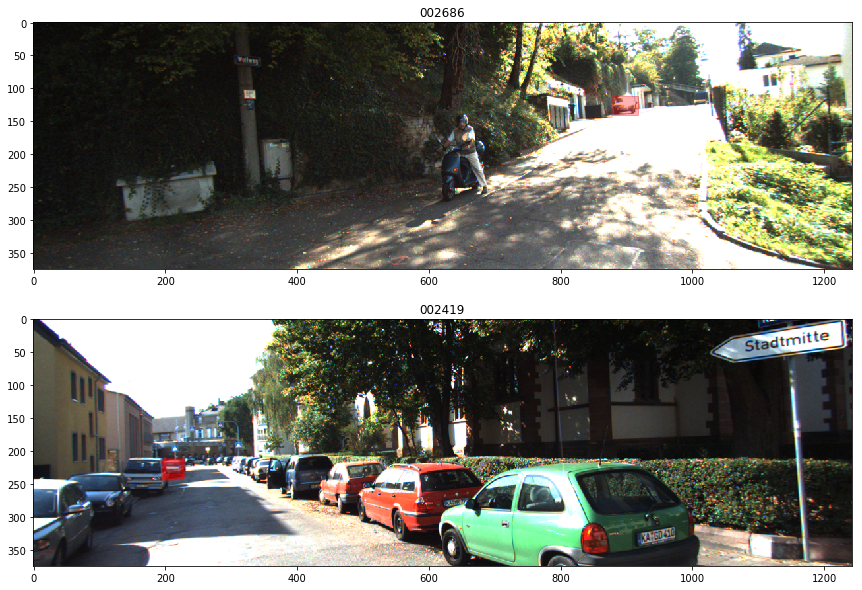

In [18]:
findings_low = [(f,d) for f in frames for d in f['detections'] \
                            if (d['label']=='Car') 
                              and d['pos_y'] < -2.1]
findings_high = [(f,d) for f in frames for d in f['detections'] \
                            if (d['label']=='Car') 
                              and d['pos_y'] > 4.0]

fig = plt.figure(figsize=(18, 10))

ax = plt.subplot(2,1,1)
cur_frame = KITTIFrameReader.create_new_frame_from_detections(findings_low[0][0], [findings_low[0][1]])
plot_helpers.plot_frame_2d(ax, cur_frame, show_image=True, show_2d=True, show_3d=False, show_info=False, show_lidar=False)
ax.set_title(cur_frame['image']['id'])
    
ax = plt.subplot(2,1,2)
cur_frame = KITTIFrameReader.create_new_frame_from_detections(findings_high[0][0], [findings_high[0][1]])
plot_helpers.plot_frame_2d(ax, cur_frame, show_image=True, show_2d=False, show_3d=True, show_info=False, show_lidar=False)
ax.set_title(cur_frame['image']['id'])
        
plt.show(fig)

These values make sense, as for the smallest value the objects seems to be uphill relative to the camera orientation (y axis points down). The same is valid for the biggest value - here the car seems to be parked downhills.

Also overpasses could create seemingly unintuitive positions of objects, as they are, by definition of an overpass, on another level. But it seems, that this dataset dow not have overpasses with labeld object on top of it.

## Pointclouds

The pointclouds are generated by a Velodyne HDL-64E [ http://www.cvlibs.net/publications/Geiger2013IJRR.pdf ], a spinning laserscanner with 64 layers. The KITTI dataset website claims that for each frame, there are 100k points of pointcloud available. So start with checking this claim.

In [19]:
num_points = np.zeros(len(frames))
for idx, f in enumerate(frames):
    points = KITTIFrameReader.get_velodyne(f)
    num_points[idx] = points.shape[0]
    
print("Min points: {}, Mean points: {}, Max points: {}"
      .format(num_points.min(), num_points.mean(), num_points.max()))
    

Min points: 78596.0, Mean points: 119224.68065766609, Max points: 128467.0


So strictly speaking, the claim is only roughly true. But at least there are no frames with points at all.

Another interesting fact is the distribution of radial distances over all frames.

In [20]:
n_bins = 10

hist_dist = np.zeros(n_bins)
hist_azim = np.zeros(n_bins)
hist_elev = np.zeros(n_bins)

hist_bins_dist = np.zeros(n_bins+1)
hist_bins_azim = np.zeros(n_bins+1)
hist_bins_elev = np.zeros(n_bins+1)

dist_stat = np.zeros((len(frames), 4))
azim_stat = np.zeros((len(frames), 4))
elev_stat = np.zeros((len(frames), 4))

for idx, f in enumerate(frames):
    points = KITTIFrameReader.get_velodyne(f)
    dist = np.sqrt(points[:,0]**2 + points[:,1]**2 + points[:,2]**2)
    azim = np.arctan2(points[:,1], points[:,0])
    elev = np.arccos(np.clip(points[:,3]/(dist+np.finfo(float).eps), -1., 1.))
    
    hist, bins = np.histogram(dist, bins=n_bins, range=(0., 85.0))
    hist_dist += hist
    hist_bins_dist = bins
    
    hist, bins = np.histogram(azim, bins=n_bins, range=(-np.pi, np.pi))
    hist_azim += hist
    hist_bins_azim = bins
    
    hist, bins = np.histogram(elev, bins=n_bins, range=(0.7, 1.6))
    hist_elev += hist
    hist_bins_elev = bins
    
    dist_stat[idx, :] = np.array([
        dist.min(), dist.mean(), dist.max(), dist.shape[0]
    ])
    
    azim_stat[idx, :] = np.array([
        azim.min(), azim.mean(), azim.max(), azim.shape[0]
    ])
    
    elev_stat[idx, :] = np.array([
        elev.min(), elev.mean(), elev.max(), elev.shape[0]
    ])
    
    
    
print("Radial distance [m] (min/max): {} / {}".format(dist_stat[:,0].min(), dist_stat[:,2].max()))
print("Azimuth [rad] (min/max): {} / {}".format(azim_stat[:,0].min(), azim_stat[:,2].max()))
print("Elevation[rad] (min/max): {} / {}".format(elev_stat[:,0].min(), elev_stat[:,2].max()))

Radial distance [m] (min/max): 1.4559663534164429 / 80.00621032714844
Azimuth [rad] (min/max): -3.1415927410125732 / 3.1415927410125732
Elevation[rad] (min/max): 0.8312391042709351 / 1.5707963705062866


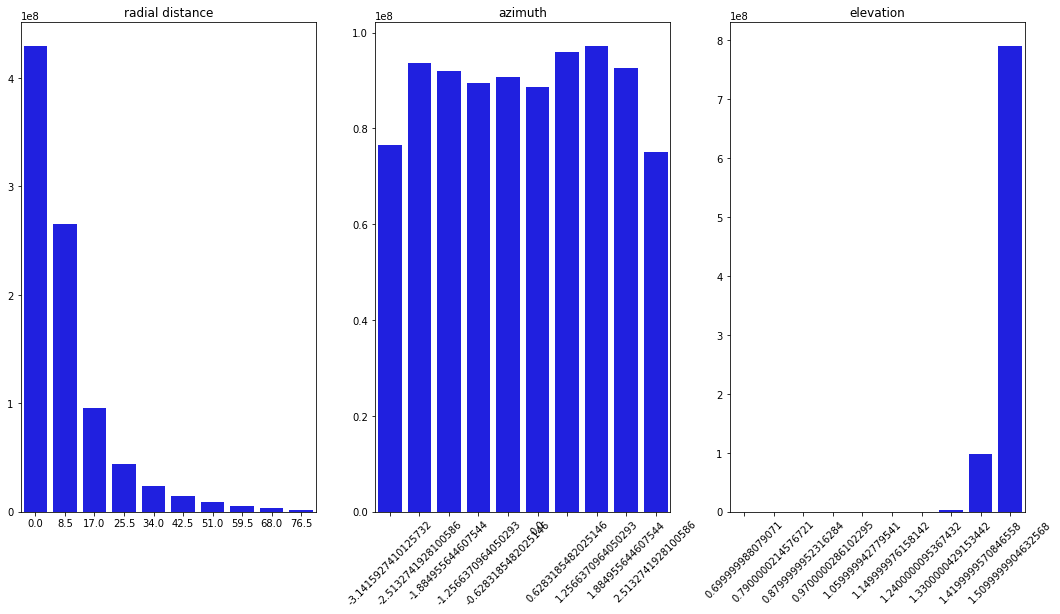

In [21]:
fig = plt.figure(figsize=(18, 9))
    
ax = plt.subplot(1,3,1)
ax.autoscale(axis='both')
ax.set_title('radial distance')
sbn.barplot(hist_bins_dist[:n_bins], hist_dist, color="blue")

ax = plt.subplot(1,3,2)
ax.autoscale(axis='both')
ax.set_title('azimuth')
sbn.barplot(hist_bins_azim[:n_bins], hist_azim, color="blue")
for item in ax.get_xticklabels():
    item.set_rotation(45)

ax = plt.subplot(1,3,3)
ax.autoscale(axis='both')
ax.set_title('elevation')
sbn.barplot(hist_bins_elev[:n_bins], hist_elev, color="blue")
for item in ax.get_xticklabels():
    item.set_rotation(45)
        
plt.show(fig)


This radial distance distribution is as expected - further away reflections are less probable as close detections (closer detections block the view into the distance).  As the Velodyne is a rotating laser, a close-to-uniform distribution is expected for the number of points in different azimuth ranges. 

Only the elevation is of concern - there are very few measurements which stretch the histogramm significantly. The value of 0.8 is not that much of a problem - a bit more than 45° relative to the z-axis is still possible. But that these are only very few measurements raises the question, why this is the case. Let's visualize a few of these frames:

There are 40 frames with low elevation.


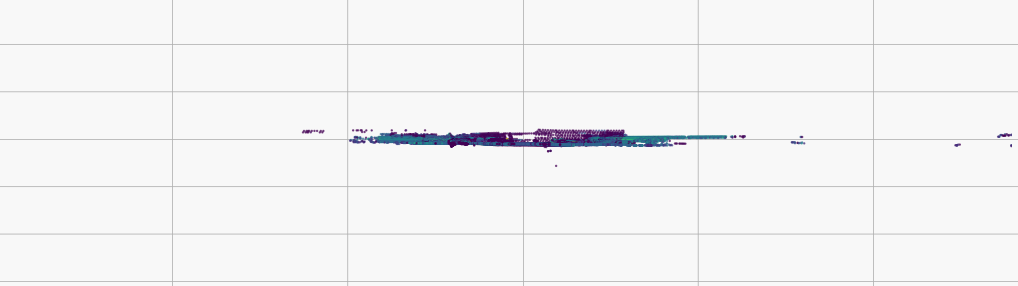

In [22]:
import plot_helpers
frames_with_low_elevation = np.where(elev_stat[:,0]<1.)

print("There are {} frames with low elevation.".format(len(frames_with_low_elevation[0])))

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

plot_helpers.plot_frame_3d(ax, frames[frames_with_low_elevation[0][0]], show_lidar=True, show_3d=False, subsample=1)
ax.view_init(elev=0, azim=0)
ax.dist = 3

It seems, that there are singular points which are detected far below the ground surface. These points should be excluded. While it is possible to have reflections far below the ground level of the recording vehicle (slopes), singular reflections which are below a reasonable threshold of the estimated ground plane should be discarded. 

### LIDAR points on object

If LIDAR should be used for object detection, some information regarding the number of LIDAR hits on objects might be of interest. For this, the association between detection and point within the pointcloud needs to be established. This is done by checking, if a particular point is on the given bounding box using the function `lidar_helpers.get_object_points`. 
With this, we can count how many points are on a particular object.

In [ ]:
import lidar_helpers
import plot_helpers
import numpy as np
import pickle

count_points = {lbl:[] for lbl in label_classes}
for f in frames:        
    # load the pointcloud for the frame
    points = KITTIFrameReader.get_velodyne(f)
    
    # for simpler calculations, transform the pointcloud into the camera coordinate system
    points_cam_ext = np.vstack((points[:,:3].T, np.ones(points.shape[0])))
    points_cam = f['calibration']['Tr_velo_to_cam'].dot(points_cam_ext)
    points_cam = points_cam[:3, :] / points_cam[3,:]
    points_cam = np.hstack((points_cam.T, points[:,3].reshape((-1,1))))
    
    for d in f['detections']:
        if d['label'] != 'DontCare':
            # get points within the bounding box
            bbox_cam = plot_helpers.create_3d_bbox(d)
            obj_points = lidar_helpers.get_object_points(points_cam, bbox_cam)

            if obj_points is not None:
                count_points[d['label']].append(obj_points.shape[0])
            else:
                count_points[d['label']].append(0)

                

# As this operation takes quite some time, it is worth saving the result:
with open('count_points.pkl', 'wb') as f: 
    pickle.dump(count_points, f)

In [ ]:
with open('count_points.pkl', 'rb') as f: 
    count_points = pickle.load(f)

fig = plt.figure(figsize=(18,10))

print("{:20} {:11} {:11} {:11} ".format(
        'Label', 
        'min count',
        'mean count',
        'max count'
    ))
print("{:-^20}+{:-^11}+{:-^11}+{:-^11} ".format("","","",""))

for idx, lbl in enumerate(label_classes):
    if not count_points[lbl]:
        continue
        
    cnt = np.array(count_points[lbl])
    # print a table
    print("{:20} {:10.2f} {:10.2f} {:10.2f}".format(
        lbl, 
        cnt.min(), cnt.mean(), cnt.max()
    ))
    
    # plot the distirbutions
    ax = plt.subplot(3, 3, idx+1)
    ax.autoscale(axis='both')
    ax.set_title("{}".format(lbl))
    sbn.distplot(cnt)

It is interesting, that there are obviously objects with very few or even no LIDAR reflections on objects. If the pointclouds should be used for object detection, these objects should be filtered out. 

### The average car

The association between points and objects now give us the possibility to visualize the "average car" class seen by the pointcloud. For this, all points which belong to cars are normalized in rotation and object size. Afterwards the normalized points are plotted into one plot. The color indicates the reflection value of the velodyne data.

For demonstration purposes, only non-occulded car instances are used.

In [ ]:
import lidar_helpers
import plot_helpers
import numpy as np

fig2 = plt.figure(figsize=(18,10))
ax = Axes3D(fig2)

vehicles_in_plot = 0
max_vehicles_in_plot = 100

for f in frames:
    if len([d for d in f['detections'] if (d['occluded']==0) and d['label']=='Car']) > 0:
        # load the pointcloud for the frame
        points = KITTIFrameReader.get_velodyne(f)

        # for simpler calculations, transform the pointcloud into the camera coordinate system
        points_cam_ext = np.vstack((points[:,:3].T, np.ones(points.shape[0])))
        points_cam = f['calibration']['Tr_velo_to_cam'].dot(points_cam_ext)
        points_cam = points_cam[:3, :] / points_cam[3,:]
        points_cam = np.hstack((points_cam.T, points[:,3].reshape((-1,1))))

        R_cam_to_velo = np.linalg.inv(f['calibration']['Tr_velo_to_cam'])
        
        for d in f['detections']:
            if d['label'] == 'Car' and d['occluded']==0:
                # get points within the bounding box
                bbox_cam = plot_helpers.create_3d_bbox(d)
                obj_points = lidar_helpers.get_object_points(points_cam, bbox_cam)

                if obj_points is not None:
                    # normalize points if they are available
                    pos_obj_cam = np.array([d['pos_x'], d['pos_y'], d['pos_z']])
                    obj_points_norm = obj_points.copy()
                    obj_points_norm[:,:3] -= pos_obj_cam # translation

                    # rotation matrix for object
                    R = np.array([[+np.cos(-d['rot_y']), 0, +np.sin(-d['rot_y'])],
                                  [0, 1, 0],
                                  [-np.sin(-d['rot_y']), 0, +np.cos(-d['rot_y'])]])

                    obj_points_norm[:,:3] = R.dot(obj_points_norm[:,:3].T).T

                    # scale to norm vehicle
                    scale_z = 3.88 / d['length']
                    scale_x = 1.63 / d['width']
                    scale_y = 1.53 / d['height']

                    obj_points_norm[:,0] *= scale_x
                    obj_points_norm[:,1] *= scale_y
                    obj_points_norm[:,2] *= scale_z

                    # for easier interpretation rotate into velodyne coordinate system
                    obj_points_norm[:, :3] = R_cam_to_velo[:3, :3].dot(obj_points_norm[:, :3].T).T

                    plot_helpers.plot_lidar_in_3d(ax, obj_points_norm, subsample=1, point_size=2, alpha=0.1)
                    
                    vehicles_in_plot += 1
                    
                    if vehicles_in_plot > max_vehicles_in_plot:
                        break
    if vehicles_in_plot > max_vehicles_in_plot:
        break

ax.auto_scale_xyz([-2.5, 2.5], [-2.5, 2.5], [0, 5])
# save for visualization
ax.view_init(elev=0, azim=0)
ax.dist = 10
plt.savefig("left_side_jupyter.png")

ax.view_init(elev=0, azim=90)
ax.dist = 10
plt.savefig("back_jupyter.png")

ax.view_init(elev=0, azim=180)
ax.dist = 10
plt.savefig("right_side_jupyter.png")

ax.view_init(elev=0, azim=-90)
ax.dist = 10
plt.savefig("front_jupyter.png")

ax.view_init(elev=20, azim=-45)
ax.dist = 10
plt.savefig("front_top_jupyter.png")

ax.view_init(elev=20, azim=135)
ax.dist = 10
plt.savefig("back_top_jupyter.png")


![alt](left_side_jupyter.png) | ![alt](front_jupyter.png)
- | - 
![alt](front_top_jupyter.png) | ![alt](back_jupyter.png)

This aggregated point cloud is clearly recognizable as a car. Using this approach to create a simplified probabilistic model of the reflectivity around the car might help to recognize vehicles or to determine its orientation. But this task stays open for another time.

## Enriching the dataset with IMU data

According to [ http://www.cvlibs.net/publications/Geiger2013IJRR.pdf ], the dataset was originally recorded with a high precision IMU (OXTS). Unfortunately this information is not included in the 3D Object Detection Evaluation dataset anymore. But as the origins of this dataset are very well documented, one can reconstruct the relation between dataset frame and "raw dataset" frame. 

The accompanying development kit for this dataset (https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_object.zip) contains valuable information: 

```
--------------------                                                              
| 3D Obj Det Frame |                                                        
--------------------                                                              
         |
         V                                                                        
mapping/train_rand.txt 
         |
         V
mapping/train_mapping.txt
         |
         V
--------------------
| * drivedate      |
| * drivenumber    |
| * frame of drive |
--------------------
```
With this information, one can match the labeled frames to the raw data. This mapping function is implemented in the `kitti_reader.KITTIRawEnhancer` class. The raw data is read using the open source 'pykitti' module and then the releavant information is stored within the before mentioned frame dictionary by just adding a key to the dictionary. For now, only adding the IMU information is implemented.

In [ ]:
from kitti_reader import KITTIRawEnhancer

enhancer_raw = KITTIRawEnhancer(r'/media/drivepx/BA0C-0F69/kitti/data/',
                                r'/media/drivepx/BA0C-0F69/kitti/data/mapping')

frames = [enhancer_raw.enhance_oxts(fr) for fr in frames if enhancer_raw.raw_exists_for_frame(fr)]

Now the `frames` list contains dictionaries with an additional key called `oxts`, which contains all the IMU data, including the GPS coordinates. For now, here is only a visualization of all the frames on a map, but this opens up much more possibilities, which would exceed the available time at hand for this task. 

In [ ]:
import gmaps
import pandas as pd

gmaps.configure(api_key="<YOUR_GMAPS_API_KEY_HERE>") # Your Google API key


df = pd.DataFrame([{'latitude': f['oxts'][0].packet.lat, 'longitude':f['oxts'][0].packet.lon} for f in frames])

df = df.iloc[::10,:] # only every 10th point to keep jupyter notebook responsive

frame_layer = gmaps.symbol_layer(
    df, fill_color="red", stroke_color="red", scale=2
)
fig = gmaps.figure()
fig.add_layer(frame_layer)

fig

![map](map.png)
By not only using one GPS point, but multiple points, map matching could be applied on a map (e.g. Open Street Maps) in order to get the node on which the recording vehicle was located. And with that even more meta data can be applied: 
* number of lanes
* potential intersections in sight
* availability of sidewalks
* potential traffic signs or traffic lights in sight
* ...

The things to add are just limited by the creativity of queries to the map database.

In order to connect the dataset to the map database, I would pursue following steps:
1. setting up the open source routing matching using docker (see https://github.com/Project-OSRM/osrm-backend)
2. setup an OSRM python binding (e.g. https://github.com/ustroetz/python-osrm)
3. Query OSRM map matching for a short sequence of GPS points for a given frame within the dataset
4. Use the map matched result in order to do further queries (e.g. for number of lanes) directly to a Open Street map database, as the link node id now is known

Unfortunately this approach exceeds the available time for this project. I might tackle this interesting possibility in a future side project.
